In [1]:
print("hello world")

hello world


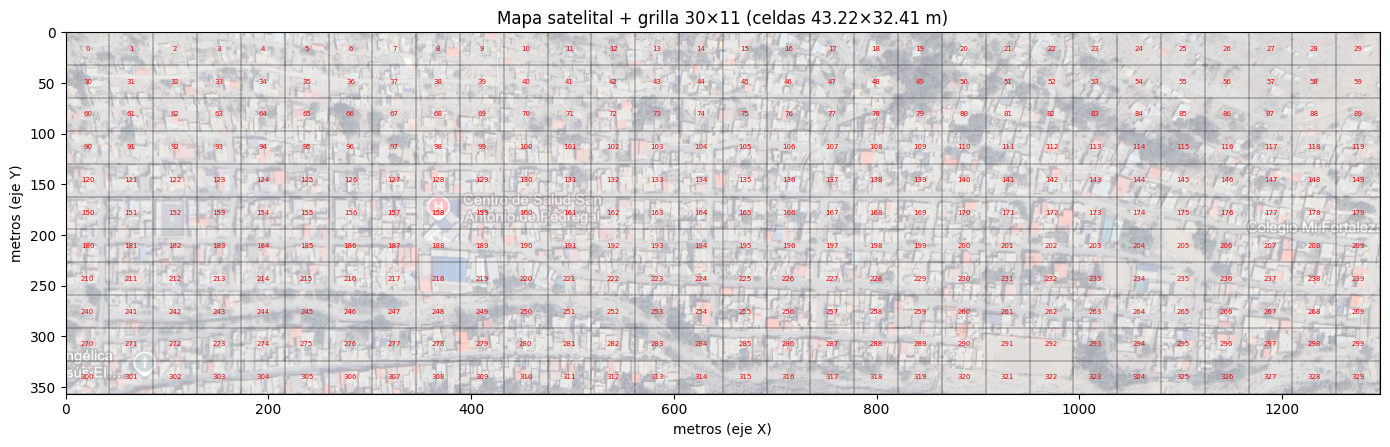

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# ------------------------------------------
# Parámetros de la grilla
# ------------------------------------------
IMG_PATH = "lurigancho_sat.png"   # tu imagen
n_cols = 30                       # ancho en celdas
n_rows = 11                       # alto en celdas

dx = 43.22    # ancho físico de celda (m)
dy = 32.41    # alto físico de celda (m)

# ------------------------------------------
# Tamaño físico real del mapa (m)
# ------------------------------------------
map_width_m  = n_cols * dx
map_height_m = n_rows * dy

# ------------------------------------------
# Cargar imagen
# ------------------------------------------
img = Image.open(IMG_PATH)

# ------------------------------------------
# Dibujar imagen escalada al tamaño físico
# ------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# extent define la imagen en coordenadas de metros reales
ax.imshow(img, extent=[0, map_width_m, map_height_m, 0], alpha=0.35)

# ------------------------------------------
# Dibujar grilla con celdas rectangulares
# ------------------------------------------
# Líneas verticales (cada dx metros)
for c in range(n_cols + 1):
    x = c * dx
    ax.axvline(x, color="black", linewidth=0.3)

# Líneas horizontales (cada dy metros)
for r in range(n_rows + 1):
    y = r * dy
    ax.axhline(y, color="black", linewidth=0.3)

# ------------------------------------------
# Numerar celdas por ID único
# ------------------------------------------
cell_id = 0
for r in range(n_rows):
    for c in range(n_cols):
        x_center = c * dx + dx / 2
        y_center = r * dy + dy / 2
        ax.text(
            x_center, y_center,
            str(cell_id),
            ha="center", va="center",
            fontsize=5, color="red"
        )
        cell_id += 1

# ------------------------------------------
# Ajustes finales
# ------------------------------------------
ax.set_xlim(0, map_width_m)
ax.set_ylim(map_height_m, 0)  # invertimos eje Y
ax.set_xlabel("metros (eje X)")
ax.set_ylabel("metros (eje Y)")
ax.set_title("Mapa satelital + grilla 30×11 (celdas 43.22×32.41 m)")

plt.tight_layout()
plt.show()


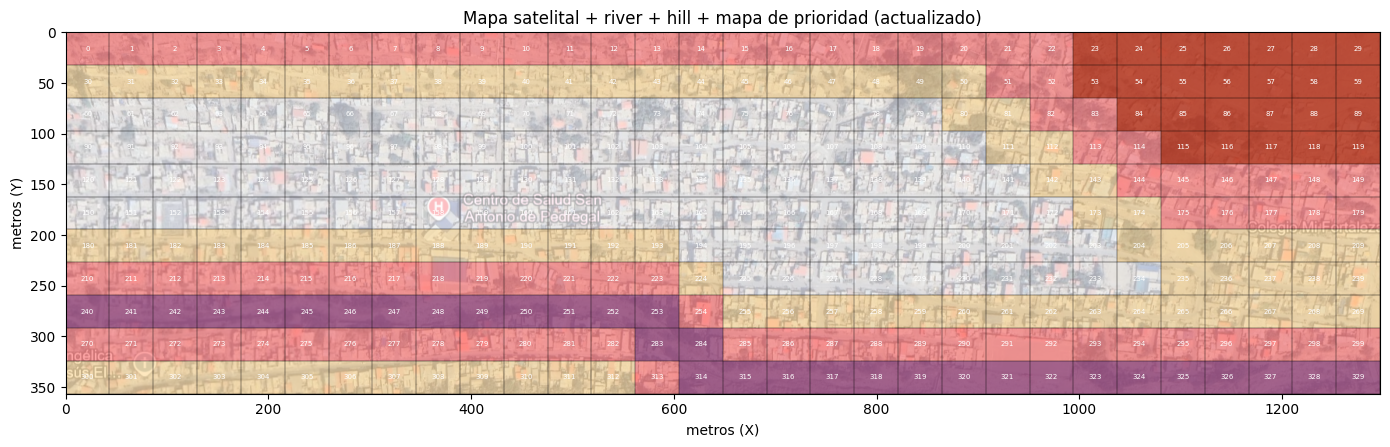

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle

# ----------------------------------------------------
# Parámetros básicos
# ----------------------------------------------------
IMG_PATH = "lurigancho_sat.png"   # <-- pon aquí tu imagen satelital
n_cols = 30
n_rows = 11

dx = 43.22    # ancho físico (m) de cada celda
dy = 32.41    # alto físico (m) de cada celda

map_width_m  = n_cols * dx
map_height_m = n_rows * dy

# ----------------------------------------------------
# Definición de celdas por ID (0..329)
# ----------------------------------------------------
# River
river_cells = set(list(range(240, 254)) + [283, 284] + list(range(314, 330)))

# Hill
hill_cells = set(
    list(range(23, 30)) +   # 23-29
    list(range(53, 60)) +   # 53-59
    list(range(84, 90)) +   # 84-89
    list(range(115, 120))   # 115-119
)

# ----------------------------------------------------
# Mapa de prioridad
# 0 = sin prioridad
# 1 = prioridad media
# 2 = prioridad alta
# ----------------------------------------------------
priority = np.zeros((n_rows, n_cols), dtype=int)

def cell_to_rc(cell_id):
    r = cell_id // n_cols
    c = cell_id % n_cols
    return r, c

# 1) Rango base que tú definiste
high_priority_cells   = set(range(0, 24))   # 0-23 prioridad alta
medium_priority_cells = set(range(30, 52))  # 30-51 prioridad media

for cid in high_priority_cells:
    r, c = cell_to_rc(cid)
    priority[r, c] = 2

for cid in medium_priority_cells:
    r, c = cell_to_rc(cid)
    if priority[r, c] < 1:  # no pisar alta
        priority[r, c] = 1

# helper: marcar vecinos Manhattan a distancia <= radios
def mark_danger_around(cells, high_radius=1, medium_radius=2):
    for cid in cells:
        r0, c0 = cell_to_rc(cid)
        for r in range(n_rows):
            for c in range(n_cols):
                dist = abs(r - r0) + abs(c - c0)
                if 1 <= dist <= high_radius:
                    priority[r, c] = max(priority[r, c], 2)  # alta
                elif high_radius < dist <= medium_radius:
                    priority[r, c] = max(priority[r, c], 1)  # media

# 2) Río: zona peligrosa 1 celda, intermedia 2 celdas
mark_danger_around(river_cells, high_radius=1, medium_radius=2)

# 3) Hill: padding de +2 alta y +2 media (o sea radio 2 y 4)
mark_danger_around(hill_cells, high_radius=2, medium_radius=4)

# ----------------------------------------------------
# Cargar imagen
# ----------------------------------------------------
img = Image.open(IMG_PATH)

# ----------------------------------------------------
# Plot
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Imagen satelital “pegada” al sistema físico
ax.imshow(img, extent=[0, map_width_m, map_height_m, 0], alpha=0.35)

# Líneas de la grilla (rectángulos con dx x dy)
for c in range(n_cols + 1):
    x = c * dx
    ax.axvline(x, color="black", linewidth=0.3)

for r in range(n_rows + 1):
    y = r * dy
    ax.axhline(y, color="black", linewidth=0.3)

# ----------------------------------------------------
# Pintar capas transparentes: river / hill / prioridad
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x0 = c * dx
    y0 = r * dy

    # Hill: obstáculo “duro”
    if cell_id in hill_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.4, 0.2, 0.0, 0.6),  # marrón oscuro semi-opaco
            edgecolor=None
        )
        ax.add_patch(rect)
        # seguimos pintando prioridad encima si quieres mezcla visual,
        # si NO quieres, pon 'continue' aquí.
        # continue

    # River
    if cell_id in river_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 0.3, 0.8, 0.5),  # azul semi-transparente
            edgecolor=None
        )
        ax.add_patch(rect)

    # Prioridad
    pr = priority[r, c]
    if pr == 2:  # alta
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(1.0, 0.0, 0.0, 0.35),  # rojo
            edgecolor=None
        )
        ax.add_patch(rect)
    elif pr == 1:  # media
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(1.0, 0.65, 0.0, 0.25),  # naranja
            edgecolor=None
        )
        ax.add_patch(rect)

# ----------------------------------------------------
# Numerar celdas
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x_center = c * dx + dx / 2
    y_center = r * dy + dy / 2
    ax.text(
        x_center, y_center,
        str(cell_id),
        ha="center", va="center",
        fontsize=5, color="white"
    )

# ----------------------------------------------------
# Ajustes finales
# ----------------------------------------------------
ax.set_xlim(0, map_width_m)
ax.set_ylim(map_height_m, 0)
ax.set_xlabel("metros (X)")
ax.set_ylabel("metros (Y)")
ax.set_title("Mapa satelital + river + hill + mapa de prioridad (actualizado)")

plt.tight_layout()
plt.show()


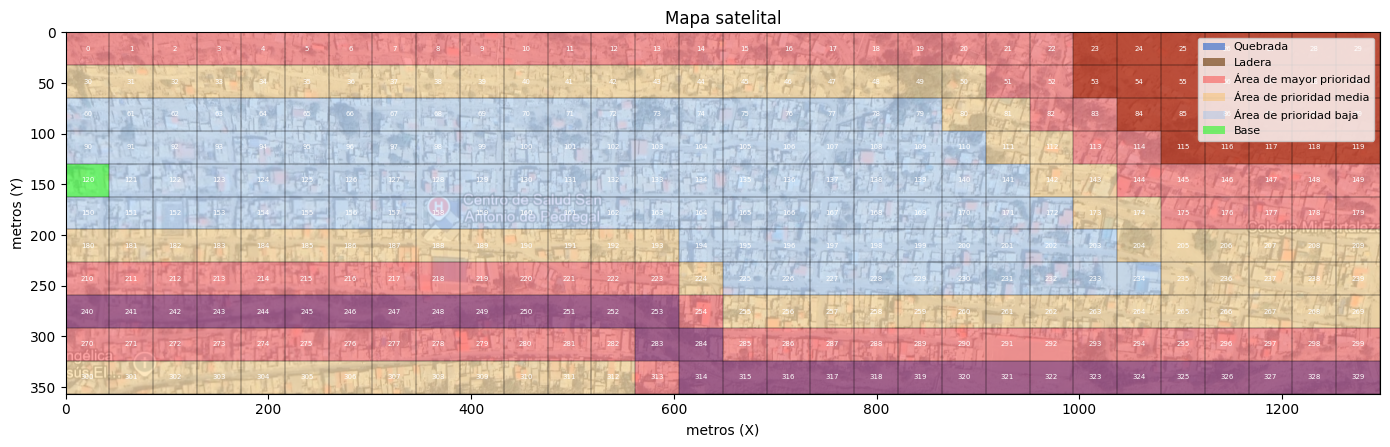

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle, Patch
import json

# ----------------------------------------------------
# Parámetros básicos
# ----------------------------------------------------
IMG_PATH = "lurigancho_sat.png"   # <-- pon aquí tu imagen satelital
n_cols = 30
n_rows = 11

dx = 43.22    # ancho físico (m) de cada celda
dy = 32.41    # alto físico (m) de cada celda

map_width_m  = n_cols * dx
map_height_m = n_rows * dy

# ----------------------------------------------------
# Definición de celdas por ID (0..329)
# ----------------------------------------------------
# River
river_cells = set(list(range(240, 254)) + [283, 284] + list(range(314, 330)))

# Hill
hill_cells = set(
    list(range(23, 30)) +   # 23-29
    list(range(53, 60)) +   # 53-59
    list(range(84, 90)) +   # 84-89
    list(range(115, 120))   # 115-119
)

# ----------------------------------------------------
# Mapa de prioridad
# 0 = sin prioridad
# 1 = prioridad media
# 2 = prioridad alta
# ----------------------------------------------------
priority = np.zeros((n_rows, n_cols), dtype=int)

def cell_to_rc(cell_id):
    r = cell_id // n_cols
    c = cell_id % n_cols
    return r, c

# 1) Rango base que definiste
high_priority_cells   = set(range(0, 24))   # 0-23 prioridad alta
medium_priority_cells = set(range(30, 52))  # 30-51 prioridad media

for cid in high_priority_cells:
    r, c = cell_to_rc(cid)
    priority[r, c] = 2

for cid in medium_priority_cells:
    r, c = cell_to_rc(cid)
    if priority[r, c] < 1:  # no pisar alta
        priority[r, c] = 1

# helper: marcar vecinos Manhattan a distancia <= radios
def mark_danger_around(cells, high_radius=1, medium_radius=2):
    for cid in cells:
        r0, c0 = cell_to_rc(cid)
        for r in range(n_rows):
            for c in range(n_cols):
                dist = abs(r - r0) + abs(c - c0)
                if 1 <= dist <= high_radius:
                    priority[r, c] = max(priority[r, c], 2)  # alta
                elif high_radius < dist <= medium_radius:
                    priority[r, c] = max(priority[r, c], 1)  # media

# 2) Río: zona peligrosa 1 celda, intermedia 2 celdas
mark_danger_around(river_cells, high_radius=1, medium_radius=2)

# 3) Hill: padding de +2 alta y +2 media (o sea radio 2 y 4)
mark_danger_around(hill_cells, high_radius=2, medium_radius=4)

# ----------------------------------------------------
# Cargar imagen
# ----------------------------------------------------
img = Image.open(IMG_PATH)

# ----------------------------------------------------
# Plot
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Imagen satelital “pegada” al sistema físico
ax.imshow(img, extent=[0, map_width_m, map_height_m, 0], alpha=0.35)

# Líneas de la grilla (rectángulos con dx x dy)
for c in range(n_cols + 1):
    x = c * dx
    ax.axvline(x, color="black", linewidth=0.3)

for r in range(n_rows + 1):
    y = r * dy
    ax.axhline(y, color="black", linewidth=0.3)

# ----------------------------------------------------
# Pintar capas transparentes: river / hill / prioridad
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x0 = c * dx
    y0 = r * dy

    # Hill: obstáculo “duro”
    if cell_id in hill_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.4, 0.2, 0.0, 0.6),  # marrón oscuro semi-opaco
            edgecolor=None
        )
        ax.add_patch(rect)
        # si NO quieres mezclar con prioridad, activa este continue:
        # continue

    # River
    if cell_id in river_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 0.3, 0.8, 0.5),  # azul semi-transparente
            edgecolor=None
        )
        ax.add_patch(rect)

    # Prioridad
    pr = priority[r, c]
    if pr == 2:  # alta
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(1.0, 0.0, 0.0, 0.35),  # rojo
            edgecolor=None
        )
        ax.add_patch(rect)
    elif pr == 1:  # media
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(1.0, 0.65, 0.0, 0.25),  # naranja
            edgecolor=None
        )
        ax.add_patch(rect)

    elif cell_id == 120: #base
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 1.0, 0.0, 0.5),  # verde semi-transparente
            edgecolor=None
        )
        ax.add_patch(rect)

    else:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.4, 0.7, 1.0, 0.25),   # celeste claro súper transparente
            edgecolor=None
        )
        ax.add_patch(rect)

# ----------------------------------------------------
# Numerar celdas
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x_center = c * dx + dx / 2
    y_center = r * dy + dy / 2
    ax.text(
        x_center, y_center,
        str(cell_id),
        ha="center", va="center",
        fontsize=5, color="white"
    )

# ----------------------------------------------------
# LEYENDA
# ----------------------------------------------------
legend_elements = [
    Patch(facecolor=(0.0, 0.3, 0.8, 0.5),  edgecolor="none", label="Quebrada"),
    Patch(facecolor=(0.4, 0.2, 0.0, 0.6),  edgecolor="none", label="Ladera"),
    Patch(facecolor=(1.0, 0.0, 0.0, 0.35), edgecolor="none", label="Área de mayor prioridad"),
    Patch(facecolor=(1.0, 0.65, 0.0, 0.25), edgecolor="none", label="Área de prioridad media"),
    Patch(facecolor=(0.4, 0.7, 1.0, 0.25),  edgecolor="none", label="Área de prioridad baja"),
    Patch(facecolor=(0.0, 1.0, 0.0, 0.5),  edgecolor="none", label="Base")
]

ax.legend(
    handles=legend_elements,
    loc="upper right",
    fontsize=8,
    framealpha=0.8
)

# ----------------------------------------------------
# Ajustes finales del plot
# ----------------------------------------------------
ax.set_xlim(0, map_width_m)
ax.set_ylim(map_height_m, 0)
ax.set_xlabel("metros (X)")
ax.set_ylabel("metros (Y)")
ax.set_title("Mapa satelital")

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# GENERAR JSON PARA ESCENARIO ETAPA 2
# ----------------------------------------------------
all_cells = set(range(n_rows * n_cols))
residential_cells = sorted(list(all_cells - river_cells - hill_cells))

scenario = {
    "name": "lurigancho_step2_scenario",
    "grid_meta": {
        "rows": n_rows,
        "cols": n_cols,
        "cell_size_m": {
            "dx": dx,
            "dy": dy
        }
    },
    "areas": {
        "river": sorted(list(river_cells)),
        "hill": sorted(list(hill_cells)),
        "residential": residential_cells
    },
    # prioridad por celda (string key para JSON limpio)
    "cell_priority": {
        str(cell_id): int(priority[cell_to_rc(cell_id)])
        for cell_id in range(n_rows * n_cols)
    },
    # terreno por celda (útil para el entorno / generador de POIs)
    "cell_terrain": {
        str(cell_id): (
            "river" if cell_id in river_cells
            else "hill" if cell_id in hill_cells
            else "residential"
        )
        for cell_id in range(n_rows * n_cols)
    }
}


In [13]:
import json

BASE_CELL = 120      # celda de la base

environment_cells = {}
cell_idx = 1  # id incremental para JSON

# ------------------------------------------------------------
# Funciones de terreno y riesgo
# ------------------------------------------------------------
def terrain_of_cell(cell_id):
    if cell_id == BASE_CELL:
        return "base"
    if cell_id in river_cells:
        return "river"
    if cell_id in hill_cells:
        return "hill"
    return "residential"

def risk_of_cell(cell_id):
    # base no tiene riesgo
    if cell_id == BASE_CELL:
        return "none"

    # hill = siempre high risk
    if cell_id in hill_cells:
        return "high"

    # river = riesgo alto (si quieres, cámbialo a medium)
    if cell_id in river_cells:
        return "high"

    # residential según priority matrix
    r, c = cell_to_rc(cell_id)
    pr = int(priority[r, c])
    if pr == 2:
        return "high"
    elif pr == 1:
        return "medium"
    else:
        return "low"

# ------------------------------------------------------------
# Generar entrada para cada celda (0..329)
# ------------------------------------------------------------
for cid in range(n_rows * n_cols):
    r, c = cell_to_rc(cid)
    terrain = terrain_of_cell(cid)
    risk = risk_of_cell(cid)

    environment_cells[str(cell_idx)] = {
        "cell_id": cid,
        "row": r,
        "col": c,
        "terrain": terrain,
        "risk_level": risk
    }

    cell_idx += 1

# ------------------------------------------------------------
# Empaquetar en JSON final
# ------------------------------------------------------------
scenario = {
    "name": "lurigancho_environment_map",
    "meta": {
        "rows": n_rows,
        "cols": n_cols,
        "dx": dx,
        "dy": dy,
        "total_cells": n_rows * n_cols,
        "base_cell": BASE_CELL
    },
    "cells": environment_cells
}

with open("lurigancho_step2_environment.json", "w", encoding="utf-8") as f:
    json.dump(scenario, f, indent=2, ensure_ascii=False)

print("Celdas procesadas:", len(environment_cells))


Celdas procesadas: 330


In [15]:
import json

BASE_CELL = 120      # celda de la base
EXCLUDE_HILL = False # OJO: aquí NO excluimos nada; solo anotamos el terreno

environment_cells = {}
cell_idx = 1  # id incremental para JSON, pero cell_id sigue siendo el index real 0..329

def risk_of_cell(cell_id):
    r, c = cell_to_rc(cell_id)
    pr = int(priority[r, c])
    if cell_id == BASE_CELL:
        return "none"
    if cell_id in hill_cells:
        return "none"
    if pr == 2:
        return "high"
    elif pr == 1:
        return "medium"
    else:
        return "low"

def terrain_of_cell(cell_id):
    if cell_id == BASE_CELL:
        return "base"
    if cell_id in river_cells:
        return "river"
    if cell_id in hill_cells:
        return "hill"
    return "residential"

# ------------------------------------------------------------
# Generar descripción del entorno celda por celda
# ------------------------------------------------------------
for cid in range(n_rows * n_cols):
    r, c = cell_to_rc(cid)
    terrain = terrain_of_cell(cid)
    risk = risk_of_cell(cid)

    environment_cells[str(cell_idx)] = {
        "cell_id": cid,
        "row": r,
        "col": c,
        "terrain": terrain,
        "risk_level": risk
    }

    cell_idx += 1

# ------------------------------------------------------------
# Empaquetar en JSON final
# ------------------------------------------------------------
scenario = {
    "name": "lurigancho_environment_map",
    "meta": {
        "rows": n_rows,
        "cols": n_cols,
        "dx": dx,
        "dy": dy,
        "total_cells": n_rows * n_cols,
        "base_cell": BASE_CELL
    },
    "cells": environment_cells
}

with open("lurigancho_step2_environment.json", "w", encoding="utf-8") as f:
    json.dump(scenario, f, indent=2, ensure_ascii=False)

print("Celdas procesadas:", len(environment_cells))


Celdas procesadas: 330


✅ Escenario guardado en lurigancho_step2_scenario_pois.json con 40 POIs.


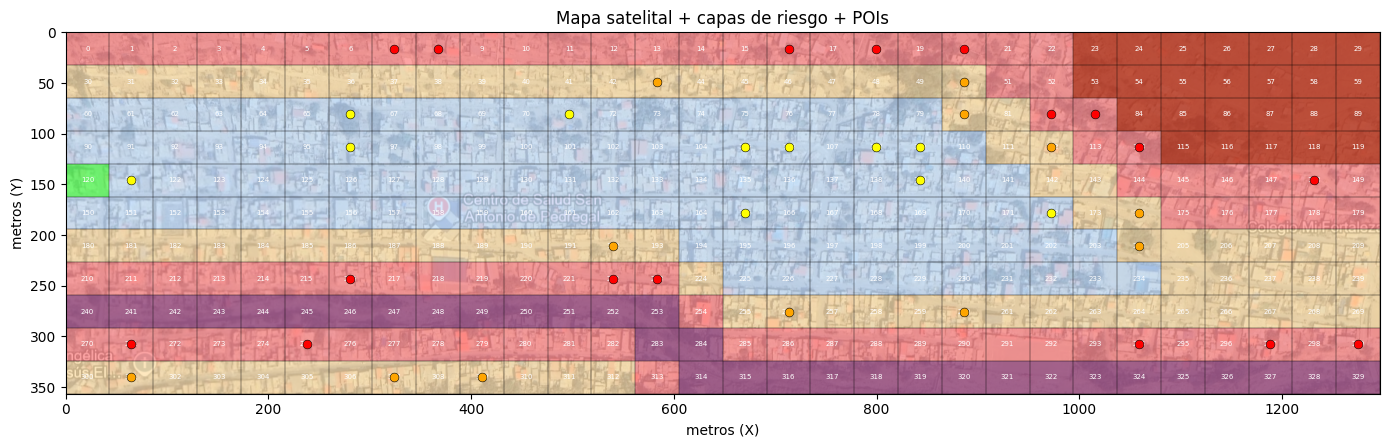

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle, Patch
import json

# ----------------------------------------------------
# Parámetros básicos
# ----------------------------------------------------
IMG_PATH = "lurigancho_sat.png"   # <-- pon aquí tu imagen satelital
n_cols = 30
n_rows = 11

dx = 43.22    # ancho físico (m) de cada celda
dy = 32.41    # alto físico (m) de cada celda

map_width_m  = n_cols * dx
map_height_m = n_rows * dy

# ----------------------------------------------------
# Definición de celdas por ID (0..329)
# ----------------------------------------------------
# River
river_cells = set(list(range(240, 254)) + [283, 284] + list(range(314, 330)))

# Hill
hill_cells = set(
    list(range(23, 30)) +   # 23-29
    list(range(53, 60)) +   # 53-59
    list(range(84, 90)) +   # 84-89
    list(range(115, 120))   # 115-119
)

BASE_CELL_ID = 120  # celda de base

# ----------------------------------------------------
# Mapa de prioridad (para riesgo)
# 0 = sin prioridad
# 1 = prioridad media
# 2 = prioridad alta
# ----------------------------------------------------
priority = np.zeros((n_rows, n_cols), dtype=int)

def cell_to_rc(cell_id):
    r = cell_id // n_cols
    c = cell_id % n_cols
    return r, c

# 1) Rango base que definiste
high_priority_cells   = set(range(0, 24))   # 0-23 prioridad alta
medium_priority_cells = set(range(30, 52))  # 30-51 prioridad media

for cid in high_priority_cells:
    r, c = cell_to_rc(cid)
    priority[r, c] = 2

for cid in medium_priority_cells:
    r, c = cell_to_rc(cid)
    if priority[r, c] < 1:  # no pisar alta
        priority[r, c] = 1

# helper: marcar vecinos Manhattan a distancia <= radios
def mark_danger_around(cells, high_radius=1, medium_radius=2):
    for cid in cells:
        r0, c0 = cell_to_rc(cid)
        for r in range(n_rows):
            for c in range(n_cols):
                dist = abs(r - r0) + abs(c - c0)
                if 1 <= dist <= high_radius:
                    priority[r, c] = max(priority[r, c], 2)  # alta
                elif high_radius < dist <= medium_radius:
                    priority[r, c] = max(priority[r, c], 1)  # media

# 2) Río: zona peligrosa 1 celda, intermedia 2 celdas
mark_danger_around(river_cells, high_radius=1, medium_radius=2)

# 3) Hill: padding de +2 alta y +2 media (o sea radio 2 y 4)
mark_danger_around(hill_cells, high_radius=2, medium_radius=4)

# ----------------------------------------------------
# Cargar imagen
# ----------------------------------------------------
img = Image.open(IMG_PATH)

# ----------------------------------------------------
# Plot
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Imagen satelital “pegada” al sistema físico
ax.imshow(img, extent=[0, map_width_m, map_height_m, 0], alpha=0.35)

# Líneas de la grilla (rectángulos con dx x dy)
for c in range(n_cols + 1):
    x = c * dx
    ax.axvline(x, color="black", linewidth=0.3)

for r in range(n_rows + 1):
    y = r * dy
    ax.axhline(y, color="black", linewidth=0.3)

# ----------------------------------------------------
# Pintar capas transparentes: river / hill / prioridad / base / resto
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x0 = c * dx
    y0 = r * dy

    # Hill: obstáculo “duro”
    if cell_id in hill_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.4, 0.2, 0.0, 0.6),  # marrón oscuro semi-opaco
            edgecolor=None
        )
        ax.add_patch(rect)
        # si NO quieres mezclar con prioridad, podrías usar "continue" aquí.
        # continue

    # River (quebrada)
    if cell_id in river_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 0.3, 0.8, 0.5),  # azul semi-transparente
            edgecolor=None
        )
        ax.add_patch(rect)

    # Prioridad (alto / medio) sobrepuesta
    pr = priority[r, c]
    if pr == 2:  # alta
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(1.0, 0.0, 0.0, 0.35),  # rojo
            edgecolor=None
        )
        ax.add_patch(rect)
    elif pr == 1:  # media
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(1.0, 0.65, 0.0, 0.25),  # naranja
            edgecolor=None
        )
        ax.add_patch(rect)
    elif cell_id == BASE_CELL_ID:  # Base
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 1.0, 0.0, 0.5),  # verde semi-transparente
            edgecolor=None
        )
        ax.add_patch(rect)
    else:
        # Área "normal" (baja prioridad / fondo celeste muy suave)
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.4, 0.7, 1.0, 0.25),   # celeste claro súper transparente
            edgecolor=None
        )
        ax.add_patch(rect)

# ----------------------------------------------------
# Numerar celdas
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x_center = c * dx + dx / 2
    y_center = r * dy + dy / 2
    ax.text(
        x_center, y_center,
        str(cell_id),
        ha="center", va="center",
        fontsize=5, color="white"
    )

# ----------------------------------------------------
# LEYENDA
# ----------------------------------------------------
legend_elements = [
    Patch(facecolor=(0.0, 0.3, 0.8, 0.5),  edgecolor="none", label="Quebrada"),
    Patch(facecolor=(0.4, 0.2, 0.0, 0.6),  edgecolor="none", label="Ladera"),
    Patch(facecolor=(1.0, 0.0, 0.0, 0.35), edgecolor="none", label="Área de mayor prioridad"),
    Patch(facecolor=(1.0, 0.65, 0.0, 0.25), edgecolor="none", label="Área de prioridad media"),
    Patch(facecolor=(0.4, 0.7, 1.0, 0.25),  edgecolor="none", label="Área de prioridad baja"),
    Patch(facecolor=(0.0, 1.0, 0.0, 0.5),   edgecolor="none", label="Base")
]



# ----------------------------------------------------
# GENERAR JSON PARA ESCENARIO ETAPA 2 + POIs
# ----------------------------------------------------
all_cells = set(range(n_rows * n_cols))
residential_cells = sorted(list(all_cells - river_cells - hill_cells))

# --- mapear prioridad -> riesgo y pesos de muestreo ---
priority_to_risk = {
    0: ("low",    1.0),
    1: ("medium", 2.0),
    2: ("high",   3.0)
}

# celdas candidatas para POIs (solo residenciales y no base)
candidate_cells = [cid for cid in residential_cells if cid != BASE_CELL_ID]

weights = []
risks_for_cell = {}
for cid in candidate_cells:
    r, c = cell_to_rc(cid)
    pr = int(priority[r, c])
    risk_label, w = priority_to_risk[pr]
    risks_for_cell[cid] = risk_label
    weights.append(w)

weights = np.array(weights, dtype=float)
weights /= weights.sum()  # normalizar

# Número de POIs que quieres en este escenario (ajusta a gusto)
N_POIS = 40

# Elegir celdas para POIs sesgadas por riesgo
chosen_cells = np.random.choice(candidate_cells, size=min(N_POIS, len(candidate_cells)),
                                replace=False, p=weights)

pois = []
for i, cid in enumerate(chosen_cells):
    r, c = cell_to_rc(cid)
    x_center = c * dx + dx / 2
    y_center = r * dy + dy / 2

    risk_label = risks_for_cell[cid]
    # mapear riesgo a priority_level 1..3 (coherente con tu config de POIs)
    if risk_label == "high":
        p_level = 3
    elif risk_label == "medium":
        p_level = 2
    else:
        p_level = 1

    poi = {
        "id": f"poi_{i}",
        "cell_id": cid,
        "row": int(r),
        "col": int(c),
        "x_center_m": float(x_center),
        "y_center_m": float(y_center),
        "terrain": "residential",
        "risk": risk_label,          # "high" / "medium" / "low"
        "priority_level": p_level    # 1,2,3
        # aquí luego puedes añadir dwell, ventanas, etc.
    }
    pois.append(poi)

# Escenario completo
scenario = {
    "name": "lurigancho_step2_scenario",
    "grid_meta": {
        "rows": n_rows,
        "cols": n_cols,
        "cell_size_m": {
            "dx": dx,
            "dy": dy
        },
        "base_cell_id": BASE_CELL_ID
    },
    "areas": {
        "river": sorted(list(river_cells)),
        "hill": sorted(list(hill_cells)),
        "residential": residential_cells
    },
    # riesgo/“prioridad” por celda (string key para JSON limpio)
    "cell_risk": {
        str(cell_id): (
            "high" if priority[cell_to_rc(cell_id)] == 2
            else "medium" if priority[cell_to_rc(cell_id)] == 1
            else "low"
        )
        for cell_id in range(n_rows * n_cols)
    },
    # terreno por celda
    "cell_terrain": {
        str(cell_id): (
            "river" if cell_id in river_cells
            else "hill" if cell_id in hill_cells
            else "residential"
        )
        for cell_id in range(n_rows * n_cols)
    },
    # lista explícita de POIs pre-muestreados
    "pois": pois
}

def to_python(obj):
    if isinstance(obj, dict):
        return {k: to_python(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [to_python(v) for v in obj]
    elif isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    else:
        return obj

scenario_py = to_python(scenario)

with open("lurigancho_step2_scenario_pois.json", "w", encoding="utf-8") as f:
    json.dump(scenario_py, f, indent=2, ensure_ascii=False)


print(f"✅ Escenario guardado en lurigancho_step2_scenario_pois.json con {len(pois)} POIs.")

# ----------------------------------------------------
# PLOTEAR LOS POIs SOBRE LA FIGURA
# ----------------------------------------------------
risk_to_color = {
    "high":   "red",
    "medium": "orange",
    "low":    "yellow"
}

for poi in pois:
    ax.scatter(
        poi["x_center_m"],
        poi["y_center_m"],
        s=40,
        c=risk_to_color[poi["risk"]],
        edgecolors="black",
        linewidths=0.4,
        zorder=5
    )

# Ajustes finales del plot
ax.set_xlim(0, map_width_m)
ax.set_ylim(map_height_m, 0)
ax.set_xlabel("metros (X)")
ax.set_ylabel("metros (Y)")
ax.set_title("Mapa satelital + capas de riesgo + POIs")

plt.tight_layout()
plt.show()


In [24]:
import json
import random
from matplotlib.patches import Circle

# =========================================================
# 1. Construir cell_terrain desde tus datos del mapa
# =========================================================
all_cells = set(range(n_rows * n_cols))

cell_terrain = {
    str(cell_id): (
        "river" if cell_id in river_cells
        else "hill" if cell_id in hill_cells
        else "residential"
    )
    for cell_id in all_cells
}

# =========================================================
# 2. APPEAR RATES POR TERRENO Y RIESGO
# =========================================================
APPEAR_RATES = {
    ("residential", "high"):   0.28,
    ("residential", "medium"): 0.15,
    ("residential", "low"):    0.05,
    ("hill", "high"):          0.03,
    ("river", "high"):         0.04
}

# =========================================================
# 3. PRIORIDAD Y RISK LEVEL
# =========================================================
PRIORITY_LEVEL_MAP = {"low": 1, "medium": 2, "high": 3}

def risk_from_priority(prio):
    if prio == 2:
        return "high"
    if prio == 1:
        return "medium"
    return "low"

# =========================================================
# 4. DISTRIBUCIÓN DE PERSONAS
# =========================================================
N_PERSONS = [0,1,2,3,4]
N_PERSONS_PROB = [0.50, 0.30, 0.12, 0.05, 0.03]

# =========================================================
# 5. DWELL Y TIME WINDOWS
# =========================================================
def sample_dwell(risk):
    if risk == "low":
        return random.randint(2,3)
    if risk == "medium":
        return random.randint(2,4)
    return random.randint(3,6)

def sample_time_window(risk):
    if risk == "low":
        p = 0.15
    elif risk == "medium":
        p = 0.35
    else:
        p = 0.6

    if random.random() > p:
        return None

    start = random.randint(60, 200)
    end   = random.randint(start+40, start+300)
    return (start, end)

# =========================================================
# 6. FUNCIÓN PARA GENERAR POIs
# =========================================================
def generate_pois(max_total=50):
    pois = {}
    poi_id_counter = 1
    reps = {}  # para guardar representativos por terreno/riesgo

    for cell_id in range(n_rows * n_cols):
        terrain = cell_terrain[str(cell_id)]

        # deducir risk desde priority
        pr = priority[cell_to_rc(cell_id)]
        risk = risk_from_priority(pr)

        rate = APPEAR_RATES.get((terrain, risk), 0)
        if random.random() > rate:
            continue

        r, c = cell_to_rc(cell_id)

        n_people = random.choices(N_PERSONS, weights=N_PERSONS_PROB)[0]
        dwell = sample_dwell(risk)
        tw = sample_time_window(risk)

        poi_data = {
            "poi_id": poi_id_counter,
            "cell_id": cell_id,
            "row": r,
            "col": c,
            "terrain": terrain,
            "risk_level": risk,
            "priority_level": PRIORITY_LEVEL_MAP[risk],
            "n_persons": n_people,
            "dwell_ticks": dwell
        }

        if tw is not None:
            poi_data["time_window_s"] = {"start": tw[0], "end": tw[1]}

        pois[str(poi_id_counter)] = poi_data

        # guardar uno representativo por terreno/riesgo
        key = (terrain, risk)
        if key not in reps:
            reps[key] = poi_data

        poi_id_counter += 1
        if poi_id_counter > max_total:
            break

    return pois, reps

# =========================================================
# 7. GENERAR POIs
# =========================================================
pois, reps = generate_pois(max_total=50)

print("\n=========== POIs REPRESENTATIVOS POR TERRENO & RIESGO ===========\n")
for key, poi in reps.items():
    print(f"{key}: {poi}")

print(f"\nTotal POIs generados: {len(pois)}\n")

# =========================================================
# 8. GUARDAR JSON
# =========================================================
scenario = {
    "name": "lurigancho_step2_full_pois",
    "grid_meta": {
        "rows": n_rows,
        "cols": n_cols,
        "cell_size_m": {"dx": dx, "dy": dy}
    },
    "base_cell": 120,
    "pois": pois
}

with open("lurigancho_step2_pois_full.json", "w", encoding="utf-8") as f:
    json.dump(scenario, f, indent=2, ensure_ascii=False)

print("✅ Archivo guardado: lurigancho_step2_pois_full.json")

# =========================================================
# 9. PLOTEAR POIs EN EL MAPA YA EXISTENTE
# =========================================================
# Colores según riesgo
RISK_COLOR = {"low": "cyan", "medium": "yellow", "high": "red"}

for poi in pois.values():
    x = poi["col"] * dx + dx/2
    y = poi["row"] * dy + dy/2
    col = RISK_COLOR[poi["risk_level"]]

    circ = Circle((x,y), radius=5, color=col, alpha=0.9)
    ax.add_patch(circ)

plt.draw()
plt.show()



=========== POIs REPRESENTATIVOS POR TERRENO & RIESGO ===========

('residential', 'high'): {'poi_id': 1, 'cell_id': 9, 'row': 0, 'col': 9, 'terrain': 'residential', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 0, 'dwell_ticks': 4}
('residential', 'medium'): {'poi_id': 4, 'cell_id': 30, 'row': 1, 'col': 0, 'terrain': 'residential', 'risk_level': 'medium', 'priority_level': 2, 'n_persons': 1, 'dwell_ticks': 2}
('residential', 'low'): {'poi_id': 8, 'cell_id': 66, 'row': 2, 'col': 6, 'terrain': 'residential', 'risk_level': 'low', 'priority_level': 1, 'n_persons': 0, 'dwell_ticks': 2}
('river', 'high'): {'poi_id': 28, 'cell_id': 251, 'row': 8, 'col': 11, 'terrain': 'river', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 1, 'dwell_ticks': 5, 'time_window_s': {'start': 152, 'end': 305}}

Total POIs generados: 39

✅ Archivo guardado: lurigancho_step2_pois_full.json


<Figure size 640x480 with 0 Axes>


=========== POIs REPRESENTATIVOS POR TERRENO & RIESGO ===========

('residential', 'high'): {'poi_id': 1, 'cell_id': 0, 'row': 0, 'col': 0, 'terrain': 'residential', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 0}
('hill', 'high'): {'poi_id': 10, 'cell_id': 24, 'row': 0, 'col': 24, 'terrain': 'hill', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 0}
('residential', 'medium'): {'poi_id': 11, 'cell_id': 38, 'row': 1, 'col': 8, 'terrain': 'residential', 'risk_level': 'medium', 'priority_level': 2, 'n_persons': 3, 'time_window_s': {'start': 63, 'end': 206}}
('residential', 'low'): {'poi_id': 16, 'cell_id': 99, 'row': 3, 'col': 9, 'terrain': 'residential', 'risk_level': 'low', 'priority_level': 1, 'n_persons': 0}
('river', 'high'): {'poi_id': 31, 'cell_id': 240, 'row': 8, 'col': 0, 'terrain': 'river', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 3, 'time_window_s': {'start': 94, 'end': 177}}

Total POIs generados: 47



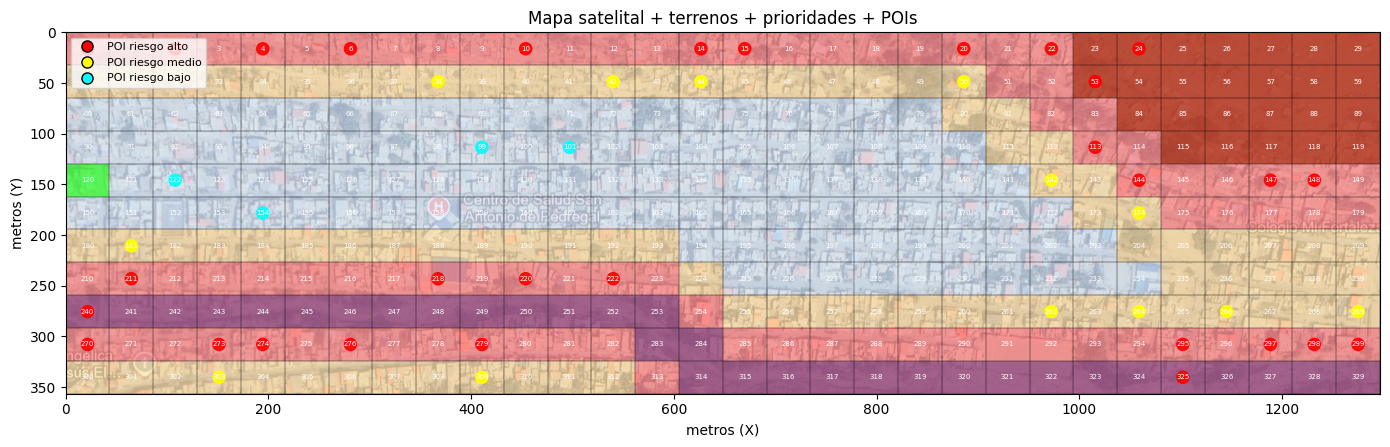

✅ Archivo guardado: lurigancho_step2_pois_full.json


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle, Patch, Circle
import json
import random

# ----------------------------------------------------
# Parámetros básicos
# ----------------------------------------------------
IMG_PATH = "lurigancho_sat.png"   # <-- pon aquí tu imagen satelital
n_cols = 30
n_rows = 11

dx = 43.22    # ancho físico (m) de cada celda
dy = 32.41    # alto físico (m) de cada celda

map_width_m  = n_cols * dx
map_height_m = n_rows * dy

# ----------------------------------------------------
# Definición de celdas por ID (0..329)
# ----------------------------------------------------
# River
river_cells = set(list(range(240, 254)) + [283, 284] + list(range(314, 330)))

# Hill
hill_cells = set(
    list(range(23, 30)) +   # 23-29
    list(range(53, 60)) +   # 53-59
    list(range(84, 90)) +   # 84-89
    list(range(115, 120))   # 115-119
)

# ----------------------------------------------------
# Mapa de prioridad (para riesgo)
# 0 = bajo
# 1 = medio
# 2 = alto
# ----------------------------------------------------
priority = np.zeros((n_rows, n_cols), dtype=int)

def cell_to_rc(cell_id: int):
    r = cell_id // n_cols
    c = cell_id % n_cols
    return r, c

# 1) Rangos base que definiste
high_priority_cells   = set(range(0, 24))   # 0-23 prioridad alta
medium_priority_cells = set(range(30, 52))  # 30-51 prioridad media

for cid in high_priority_cells:
    r, c = cell_to_rc(cid)
    priority[r, c] = 2

for cid in medium_priority_cells:
    r, c = cell_to_rc(cid)
    if priority[r, c] < 1:  # no pisar alta
        priority[r, c] = 1

# helper: marcar vecinos Manhattan a distancia <= radios
def mark_danger_around(cells, high_radius=1, medium_radius=2):
    for cid in cells:
        r0, c0 = cell_to_rc(cid)
        for r in range(n_rows):
            for c in range(n_cols):
                dist = abs(r - r0) + abs(c - c0)
                if 1 <= dist <= high_radius:
                    priority[r, c] = max(priority[r, c], 2)  # alta
                elif high_radius < dist <= medium_radius:
                    priority[r, c] = max(priority[r, c], 1)  # media

# 2) Río: zona peligrosa 1 celda, intermedia 2 celdas
mark_danger_around(river_cells, high_radius=1, medium_radius=2)

# 3) Hill: padding de +2 alta y +2 media (o sea radio 2 y 4)
mark_danger_around(hill_cells, high_radius=2, medium_radius=4)

# ----------------------------------------------------
# Terreno por celda
# ----------------------------------------------------
all_cells = set(range(n_rows * n_cols))
cell_terrain = {
    str(cell_id): (
        "river" if cell_id in river_cells
        else "hill" if cell_id in hill_cells
        else "residential"
    )
    for cell_id in all_cells
}

# ----------------------------------------------------
# Riesgo desde prioridad
# ----------------------------------------------------
def risk_from_priority(prio: int) -> str:
    if prio == 2:
        return "high"
    if prio == 1:
        return "medium"
    return "low"

PRIORITY_LEVEL_MAP = {"low": 1, "medium": 2, "high": 3}

# ----------------------------------------------------
# Parámetros de generación de POIs
# ----------------------------------------------------
# Probabilidad de que exista un POI en una celda según (terrain, risk)
APPEAR_RATES = {
    ("residential", "high"):   0.28,
    ("residential", "medium"): 0.15,
    ("residential", "low"):    0.05,
    ("hill", "high"):          0.03,
    ("river", "high"):         0.04
}

# Distribución de número de personas
N_PERSONS = [0, 1, 2, 3, 4]
N_PERSONS_PROB = [0.50, 0.30, 0.12, 0.05, 0.03]

def sample_dwell(risk: str) -> int:
    if risk == "low":
        return random.randint(2, 3)
    if risk == "medium":
        return random.randint(2, 4)
    return random.randint(3, 6)

def sample_time_window(risk: str):
    # prob. de tener ventana activa según riesgo
    if risk == "low":
        p = 0.15
    elif risk == "medium":
        p = 0.35
    else:
        p = 0.6

    if random.random() > p:
        return None

    start = random.randint(60, 200)
    end   = random.randint(start + 40, start + 300)
    return (start, end)

# ----------------------------------------------------
# Generador de POIs
# ----------------------------------------------------
def generate_pois(max_total=50):
    pois = {}
    poi_id_counter = 1
    reps = {}  # uno representativo por (terrain, risk)

    for cell_id in range(n_rows * n_cols):
        terrain = cell_terrain[str(cell_id)]
        r, c = cell_to_rc(cell_id)
        pr = int(priority[r, c])
        risk = risk_from_priority(pr)

        rate = APPEAR_RATES.get((terrain, risk), 0.0)
        if rate <= 0.0:
            continue

        # Decide si hay POI en esta celda
        if random.random() > rate:
            continue

        n_people = random.choices(N_PERSONS, weights=N_PERSONS_PROB)[0]
        dwell = sample_dwell(risk)
        tw = sample_time_window(risk)

        poi_data = {
            "poi_id": poi_id_counter,
            "cell_id": int(cell_id),
            "row": int(r),
            "col": int(c),
            "terrain": terrain,
            "risk_level": risk,
            "priority_level": int(PRIORITY_LEVEL_MAP[risk]),
            "n_persons": int(n_people),
        }
        if tw is not None:
            poi_data["time_window_s"] = {
                "start": int(tw[0]),
                "end": int(tw[1])
            }

        pois[str(poi_id_counter)] = poi_data

        key = (terrain, risk)
        if key not in reps:
            reps[key] = poi_data

        poi_id_counter += 1
        if poi_id_counter > max_total:
            break

    return pois, reps

# ----------------------------------------------------
# Cargar imagen
# ----------------------------------------------------
img = Image.open(IMG_PATH)

# ----------------------------------------------------
# Crear figura y eje
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Imagen satelital “pegada” al sistema físico
ax.imshow(img, extent=[0, map_width_m, map_height_m, 0], alpha=0.35)

# Líneas de la grilla
for c in range(n_cols + 1):
    x = c * dx
    ax.axvline(x, color="black", linewidth=0.3)

for r in range(n_rows + 1):
    y = r * dy
    ax.axhline(y, color="black", linewidth=0.3)

# ----------------------------------------------------
# Pintar capas transparentes: river / hill / prioridad / base / resto
# ----------------------------------------------------
BASE_CELL = 120

for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x0 = c * dx
    y0 = r * dy

    # Hill
    if cell_id in hill_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.4, 0.2, 0.0, 0.6),  # marrón
            edgecolor=None
        )
        ax.add_patch(rect)

    # River
    if cell_id in river_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 0.3, 0.8, 0.5),  # azul
            edgecolor=None
        )
        ax.add_patch(rect)

    pr = int(priority[r, c])

    # Base
    if cell_id == BASE_CELL:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 1.0, 0.0, 0.6),  # verde
            edgecolor=None
        )
        ax.add_patch(rect)
    else:
        # Prioridad
        if pr == 2:  # alta
            rect = Rectangle(
                (x0, y0), dx, dy,
                facecolor=(1.0, 0.0, 0.0, 0.35),  # rojo
                edgecolor=None
            )
            ax.add_patch(rect)
        elif pr == 1:  # media
            rect = Rectangle(
                (x0, y0), dx, dy,
                facecolor=(1.0, 0.65, 0.0, 0.25),  # naranja
                edgecolor=None
            )
            ax.add_patch(rect)
        else:
            # celdas residenciales de prioridad baja: capa casi transparente
            rect = Rectangle(
                (x0, y0), dx, dy,
                facecolor=(0.4, 0.7, 1.0, 0.15),
                edgecolor=None
            )
            ax.add_patch(rect)

# ----------------------------------------------------
# Numerar celdas
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x_center = c * dx + dx / 2
    y_center = r * dy + dy / 2
    ax.text(
        x_center, y_center,
        str(cell_id),
        ha="center", va="center",
        fontsize=5, color="white"
    )

# ----------------------------------------------------
# Generar POIs
# ----------------------------------------------------
pois, reps = generate_pois(max_total=50)

print("\n=========== POIs REPRESENTATIVOS POR TERRENO & RIESGO ===========\n")
for key, poi in reps.items():
    print(f"{key}: {poi}")
print(f"\nTotal POIs generados: {len(pois)}\n")

# ----------------------------------------------------
# Plotear POIs en el mapa
# ----------------------------------------------------
RISK_COLOR = {"low": "cyan", "medium": "yellow", "high": "red"}

for poi in pois.values():
    x = poi["col"] * dx + dx / 2
    y = poi["row"] * dy + dy / 2
    col = RISK_COLOR[poi["risk_level"]]
    circ = Circle((x, y), radius=6, color=col, alpha=0.9)
    ax.add_patch(circ)

# ----------------------------------------------------
# Leyenda: capas + POIs
# ----------------------------------------------------
terrain_legend = [
    Patch(facecolor=(0.0, 0.3, 0.8, 0.5),  edgecolor="none", label="Quebrada"),
    Patch(facecolor=(0.4, 0.2, 0.0, 0.6),  edgecolor="none", label="Ladera"),
    Patch(facecolor=(1.0, 0.0, 0.0, 0.35), edgecolor="none", label="Área de mayor prioridad"),
    Patch(facecolor=(1.0, 0.65, 0.0, 0.25), edgecolor="none", label="Área de prioridad media"),
    Patch(facecolor=(0.4, 0.7, 1.0, 0.15), edgecolor="none", label="Área de prioridad baja"),
    Patch(facecolor=(0.0, 1.0, 0.0, 0.6),  edgecolor="none", label="Base")
]

# handles “fake” para POIs según riesgo
from matplotlib.lines import Line2D
poi_legend = [
    Line2D([0], [0], marker="o", color="none", markerfacecolor="red",    markersize=8, label="POI riesgo alto"),
    Line2D([0], [0], marker="o", color="none", markerfacecolor="yellow", markersize=8, label="POI riesgo medio"),
    Line2D([0], [0], marker="o", color="none", markerfacecolor="cyan",   markersize=8, label="POI riesgo bajo")
]

ax.legend(
    handles=poi_legend,
    loc="upper left",
    fontsize=8,
    framealpha=0.8
)

# ----------------------------------------------------
# Ajustes finales del plot
# ----------------------------------------------------
ax.set_xlim(0, map_width_m)
ax.set_ylim(map_height_m, 0)
ax.set_xlabel("metros (X)")
ax.set_ylabel("metros (Y)")
ax.set_title("Mapa satelital + terrenos + prioridades + POIs")

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Guardar JSON de POIs
# ----------------------------------------------------
scenario = {
    "name": "lurigancho_step2_full_pois",
    "grid_meta": {
        "rows": n_rows,
        "cols": n_cols,
        "cell_size_m": {"dx": dx, "dy": dy}
    },
    "base_cell": BASE_CELL,
    "pois": pois
}

with open("lurigancho_step2_pois_full.json", "w", encoding="utf-8") as f:
    json.dump(scenario, f, indent=2, ensure_ascii=False)

print("✅ Archivo guardado: lurigancho_step2_pois_full.json")



=========== POIs REPRESENTATIVOS POR TERRENO & RIESGO ===========

('residential', 'high'): {'poi_id': 1, 'cell_id': 2, 'row': 0, 'col': 2, 'terrain': 'residential', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 0, 'dwell_ticks_base': 5}
('hill', 'high'): {'poi_id': 11, 'cell_id': 24, 'row': 0, 'col': 24, 'terrain': 'hill', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 4, 'dwell_ticks_base': 5}
('residential', 'medium'): {'poi_id': 12, 'cell_id': 31, 'row': 1, 'col': 1, 'terrain': 'residential', 'risk_level': 'medium', 'priority_level': 2, 'n_persons': 1, 'dwell_ticks_base': 2}
('residential', 'low'): {'poi_id': 17, 'cell_id': 65, 'row': 2, 'col': 5, 'terrain': 'residential', 'risk_level': 'low', 'priority_level': 1, 'n_persons': 0, 'dwell_ticks_base': 3}
('river', 'high'): {'poi_id': 42, 'cell_id': 245, 'row': 8, 'col': 5, 'terrain': 'river', 'risk_level': 'high', 'priority_level': 3, 'n_persons': 3, 'dwell_ticks_base': 6}

Total POIs generados: 50

Total obstácul

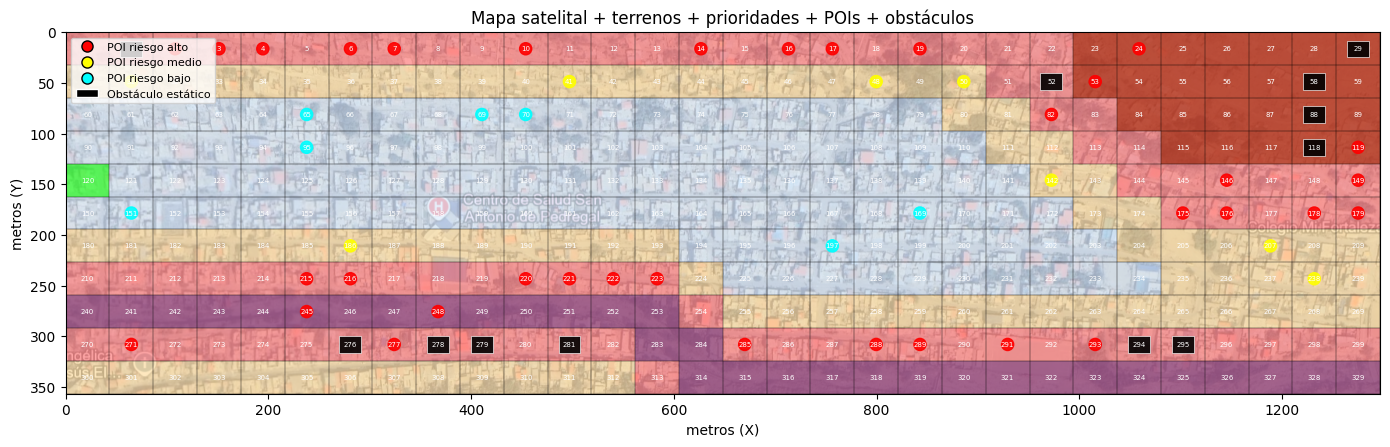

✅ Archivo guardado: lurigancho_step2_pois_full.json


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle, Patch, Circle
from matplotlib.lines import Line2D
import json
import random

# ----------------------------------------------------
# Parámetros básicos
# ----------------------------------------------------
IMG_PATH = "lurigancho_sat.png"   # <-- pon aquí tu imagen satelital
n_cols = 30
n_rows = 11

dx = 43.22    # ancho físico (m) de cada celda
dy = 32.41    # alto físico (m) de cada celda

map_width_m  = n_cols * dx
map_height_m = n_rows * dy

# ----------------------------------------------------
# Definición de celdas por ID (0..329)
# ----------------------------------------------------
# River
river_cells = set(list(range(240, 254)) + [283, 284] + list(range(314, 330)))

# Hill
hill_cells = set(
    list(range(23, 30)) +   # 23-29
    list(range(53, 60)) +   # 53-59
    list(range(84, 90)) +   # 84-89
    list(range(115, 120))   # 115-119
)

# ----------------------------------------------------
# Mapa de prioridad (para riesgo)
# 0 = bajo
# 1 = medio
# 2 = alto
# ----------------------------------------------------
priority = np.zeros((n_rows, n_cols), dtype=int)

def cell_to_rc(cell_id: int):
    r = cell_id // n_cols
    c = cell_id % n_cols
    return r, c

# 1) Rangos base que definiste
high_priority_cells   = set(range(0, 24))   # 0-23 prioridad alta
medium_priority_cells = set(range(30, 52))  # 30-51 prioridad media

for cid in high_priority_cells:
    r, c = cell_to_rc(cid)
    priority[r, c] = 2

for cid in medium_priority_cells:
    r, c = cell_to_rc(cid)
    if priority[r, c] < 1:  # no pisar alta
        priority[r, c] = 1

# helper: marcar vecinos Manhattan a distancia <= radios
def mark_danger_around(cells, high_radius=1, medium_radius=2):
    for cid in cells:
        r0, c0 = cell_to_rc(cid)
        for r in range(n_rows):
            for c in range(n_cols):
                dist = abs(r - r0) + abs(c - c0)
                if 1 <= dist <= high_radius:
                    priority[r, c] = max(priority[r, c], 2)  # alta
                elif high_radius < dist <= medium_radius:
                    priority[r, c] = max(priority[r, c], 1)  # media

# 2) Río: zona peligrosa 1 celda, intermedia 2 celdas
mark_danger_around(river_cells, high_radius=1, medium_radius=2)

# 3) Hill: padding de +2 alta y +2 media (o sea radio 2 y 4)
mark_danger_around(hill_cells, high_radius=2, medium_radius=4)

# ----------------------------------------------------
# Terreno por celda
# ----------------------------------------------------
all_cells = set(range(n_rows * n_cols))
cell_terrain = {
    str(cell_id): (
        "river" if cell_id in river_cells
        else "hill" if cell_id in hill_cells
        else "residential"
    )
    for cell_id in all_cells
}

# ----------------------------------------------------
# Riesgo desde prioridad
# ----------------------------------------------------
def risk_from_priority(prio: int) -> str:
    if prio == 2:
        return "high"
    if prio == 1:
        return "medium"
    return "low"

PRIORITY_LEVEL_MAP = {"low": 1, "medium": 2, "high": 3}

# ----------------------------------------------------
# Parámetros de generación de POIs
# ----------------------------------------------------
# Probabilidad de que exista un POI en una celda según (terrain, risk)
APPEAR_RATES = {
    ("residential", "high"):   0.28,
    ("residential", "medium"): 0.15,
    ("residential", "low"):    0.05,
    ("hill", "high"):          0.03,
    ("river", "high"):         0.04
}

# Distribución de número de personas
N_PERSONS = [0, 1, 2, 3, 4]
N_PERSONS_PROB = [0.50, 0.30, 0.12, 0.05, 0.03]

def sample_dwell(risk: str) -> int:
    # ticks base (sin persons); luego el entorno puede sumar extra_tick_per_person
    if risk == "low":
        return random.randint(2, 3)
    if risk == "medium":
        return random.randint(2, 4)
    return random.randint(3, 6)

def sample_time_window(risk: str):
    # prob. de tener ventana activa según riesgo
    if risk == "low":
        p = 0.15
    elif risk == "medium":
        p = 0.35
    else:
        p = 0.6

    if random.random() > p:
        return None

    start = random.randint(60, 200)
    end   = random.randint(start + 40, start + 300)
    return (start, end)

# ----------------------------------------------------
# Generador de POIs
# ----------------------------------------------------
def generate_pois(max_total=50):
    pois = {}
    poi_id_counter = 1
    reps = {}  # uno representativo por (terrain, risk)

    for cell_id in range(n_rows * n_cols):
        terrain = cell_terrain[str(cell_id)]
        r, c = cell_to_rc(cell_id)
        pr = int(priority[r, c])
        risk = risk_from_priority(pr)

        rate = APPEAR_RATES.get((terrain, risk), 0.0)
        if rate <= 0.0:
            continue

        # Decide si hay POI en esta celda
        if random.random() > rate:
            continue

        n_people = random.choices(N_PERSONS, weights=N_PERSONS_PROB)[0]
        dwell = sample_dwell(risk)
        tw = sample_time_window(risk)

        poi_data = {
            "poi_id": poi_id_counter,
            "cell_id": int(cell_id),
            "row": int(r),
            "col": int(c),
            "terrain": terrain,
            "risk_level": risk,
            "priority_level": int(PRIORITY_LEVEL_MAP[risk]),
            "n_persons": int(n_people),
            "dwell_ticks_base": int(dwell)
        }
        if tw is not None:
            poi_data["time_window_s"] = {
                "start": int(tw[0]),
                "end": int(tw[1])
            }

        pois[str(poi_id_counter)] = poi_data

        key = (terrain, risk)
        if key not in reps:
            reps[key] = poi_data

        poi_id_counter += 1
        if poi_id_counter > max_total:
            break

    return pois, reps

# ----------------------------------------------------
# Generador de obstáculos
# ----------------------------------------------------
def generate_obstacles(pois_dict, max_total=12):
    """
    Obstáculos:
      - En celdas hill (ladera).
      - En celdas residential + riesgo alto en franja superior (filas 0-1)
        e inferior (filas 9-10).
      - Nunca en una celda que ya tenga POI.
    """
    poi_cells = {poi["cell_id"] for poi in pois_dict.values()}
    obstacles = {}
    obs_id = 1

    candidate_cells = []

    # 1) Hill (preferimos celdas de ladera con riesgo alto)
    for cid in hill_cells:
        r, c = cell_to_rc(cid)
        risk = risk_from_priority(int(priority[r, c]))
        if risk == "high" and cid not in poi_cells:
            candidate_cells.append(cid)

    # 2) Residential + high risk en franjas superior e inferior
    top_rows = {0, 1}
    bottom_rows = {9, 10}

    for cid in all_cells:
        if cid in hill_cells or cid in river_cells:
            continue
        terrain = cell_terrain[str(cid)]
        if terrain != "residential":
            continue

        r, c = cell_to_rc(cid)
        risk = risk_from_priority(int(priority[r, c]))
        if risk != "high":
            continue

        if (r in top_rows or r in bottom_rows) and cid not in poi_cells:
            candidate_cells.append(cid)

    random.shuffle(candidate_cells)
    chosen_cells = candidate_cells[:max_total]

    for cid in chosen_cells:
        r, c = cell_to_rc(cid)
        terrain = cell_terrain[str(cid)]
        risk = risk_from_priority(int(priority[r, c]))

        obstacles[str(obs_id)] = {
            "obstacle_id": int(obs_id),
            "cell_id": int(cid),
            "row": int(r),
            "col": int(c),
            "terrain": terrain,
            "risk_level": risk,
            "kind": "static_obstacle"
        }
        obs_id += 1

    return obstacles

# ----------------------------------------------------
# Cargar imagen
# ----------------------------------------------------
img = Image.open(IMG_PATH)

# ----------------------------------------------------
# Crear figura y eje
# ----------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Imagen satelital “pegada” al sistema físico
ax.imshow(img, extent=[0, map_width_m, map_height_m, 0], alpha=0.35)

# Líneas de la grilla
for c in range(n_cols + 1):
    x = c * dx
    ax.axvline(x, color="black", linewidth=0.3)

for r in range(n_rows + 1):
    y = r * dy
    ax.axhline(y, color="black", linewidth=0.3)

# ----------------------------------------------------
# Pintar capas transparentes: river / hill / prioridad / base / resto
# ----------------------------------------------------
BASE_CELL = 120

for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x0 = c * dx
    y0 = r * dy

    # Hill
    if cell_id in hill_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.4, 0.2, 0.0, 0.6),  # marrón
            edgecolor=None
        )
        ax.add_patch(rect)

    # River
    if cell_id in river_cells:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 0.3, 0.8, 0.5),  # azul
            edgecolor=None
        )
        ax.add_patch(rect)

    pr = int(priority[r, c])

    # Base
    if cell_id == BASE_CELL:
        rect = Rectangle(
            (x0, y0), dx, dy,
            facecolor=(0.0, 1.0, 0.0, 0.6),  # verde
            edgecolor=None
        )
        ax.add_patch(rect)
    else:
        # Prioridad
        if pr == 2:  # alta
            rect = Rectangle(
                (x0, y0), dx, dy,
                facecolor=(1.0, 0.0, 0.0, 0.35),  # rojo
                edgecolor=None
            )
            ax.add_patch(rect)
        elif pr == 1:  # media
            rect = Rectangle(
                (x0, y0), dx, dy,
                facecolor=(1.0, 0.65, 0.0, 0.25),  # naranja
                edgecolor=None
            )
            ax.add_patch(rect)
        else:
            rect = Rectangle(
                (x0, y0), dx, dy,
                facecolor=(0.4, 0.7, 1.0, 0.15),  # celeste muy suave
                edgecolor=None
            )
            ax.add_patch(rect)

# ----------------------------------------------------
# Numerar celdas
# ----------------------------------------------------
for cell_id in range(n_rows * n_cols):
    r, c = cell_to_rc(cell_id)
    x_center = c * dx + dx / 2
    y_center = r * dy + dy / 2
    ax.text(
        x_center, y_center,
        str(cell_id),
        ha="center", va="center",
        fontsize=5, color="white"
    )

# ----------------------------------------------------
# Generar POIs
# ----------------------------------------------------
pois, reps = generate_pois(max_total=50)

print("\n=========== POIs REPRESENTATIVOS POR TERRENO & RIESGO ===========\n")
for key, poi in reps.items():
    print(f"{key}: {poi}")
print(f"\nTotal POIs generados: {len(pois)}\n")

# ----------------------------------------------------
# Generar obstáculos
# ----------------------------------------------------
obstacles = generate_obstacles(pois, max_total=12)
print(f"Total obstáculos generados: {len(obstacles)}\n")

# ----------------------------------------------------
# Plotear POIs en el mapa
# ----------------------------------------------------
RISK_COLOR = {"low": "cyan", "medium": "yellow", "high": "red"}

for poi in pois.values():
    x = poi["col"] * dx + dx / 2
    y = poi["row"] * dy + dy / 2
    col = RISK_COLOR[poi["risk_level"]]
    circ = Circle((x, y), radius=6, color=col, alpha=0.9)
    ax.add_patch(circ)

# ----------------------------------------------------
# Plotear obstáculos
# ----------------------------------------------------
for obs in obstacles.values():
    x0 = obs["col"] * dx + dx * 0.25
    y0 = obs["row"] * dy + dy * 0.25
    rect = Rectangle(
        (x0, y0),
        dx * 0.5, dy * 0.5,
        facecolor="black",
        edgecolor="white",
        linewidth=0.5,
        alpha=0.9
    )
    ax.add_patch(rect)

# ----------------------------------------------------
# Leyenda: capas + POIs + obstáculos
# ----------------------------------------------------
terrain_legend = [
    Patch(facecolor=(0.0, 0.3, 0.8, 0.5),  edgecolor="none", label="Quebrada"),
    Patch(facecolor=(0.4, 0.2, 0.0, 0.6),  edgecolor="none", label="Ladera"),
    Patch(facecolor=(1.0, 0.0, 0.0, 0.35), edgecolor="none", label="Área de mayor prioridad"),
    Patch(facecolor=(1.0, 0.65, 0.0, 0.25), edgecolor="none", label="Área de prioridad media"),
    Patch(facecolor=(0.4, 0.7, 1.0, 0.15), edgecolor="none", label="Área de prioridad baja"),
    Patch(facecolor=(0.0, 1.0, 0.0, 0.6),  edgecolor="none", label="Base")
]

poi_legend = [
    Line2D([0], [0], marker="o", color="none", markerfacecolor="red",    markersize=8, label="POI riesgo alto"),
    Line2D([0], [0], marker="o", color="none", markerfacecolor="yellow", markersize=8, label="POI riesgo medio"),
    Line2D([0], [0], marker="o", color="none", markerfacecolor="cyan",   markersize=8, label="POI riesgo bajo"),
    Patch(facecolor="black", edgecolor="white", label="Obstáculo estático")
]

ax.legend(
    handles=poi_legend,
    loc="upper left",
    fontsize=8,
    framealpha=0.8
)

# ----------------------------------------------------
# Ajustes finales del plot
# ----------------------------------------------------
ax.set_xlim(0, map_width_m)
ax.set_ylim(map_height_m, 0)
ax.set_xlabel("metros (X)")
ax.set_ylabel("metros (Y)")
ax.set_title("Mapa satelital + terrenos + prioridades + POIs + obstáculos")

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Guardar JSON de POIs + obstáculos
# ----------------------------------------------------
scenario = {
    "name": "lurigancho_step2_full_pois",
    "grid_meta": {
        "rows": n_rows,
        "cols": n_cols,
        "cell_size_m": {"dx": dx, "dy": dy}
    },
    "base_cell": int(BASE_CELL),
    "pois": pois,
    "obstacles": obstacles
}

with open("lurigancho_step2_pois_full.json", "w", encoding="utf-8") as f:
    json.dump(scenario, f, indent=2, ensure_ascii=False)

print("✅ Archivo guardado: lurigancho_step2_pois_full.json")
